In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using StatsBase, Distributions, Plots, LinearAlgebra, Plots

In [6]:
using Revise

includet("../src/ESGModels/msvar.jl")
includet("../src/ESGModels/msvar_gibs.jl")
includet("../src/ESGModels/msvar_simulate.jl") 

In [194]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [-.02 .35 .25; .035 .15 .63]
Σ2 = cor2cov([1 .35; .35 1], [.18, .035])


transition_matrix = [.85 .15;.2 .8]

states_zero = [.9, .1]
X = [.12, .06]


n_samples = 1000
test_regimes = simulate_regimes(states_zero, transition_matrix, n_samples, 1)
test_returns = simulate_msvar_returns(test_regimes, [Β1, Β2], [Σ1, Σ2], X, n_samples, 1)[:,:,1]'

1000×2 adjoint(::Matrix{Float64}) with eltype Float64:
  0.178562   0.0815958
  0.221563   0.115526
  0.0464621  0.167674
  0.169032   0.154635
  0.216688   0.148176
  0.0208448  0.136763
 -0.250523   0.0837464
 -0.0118868  0.069093
  0.0678698  0.0471332
  0.0481536  0.105839
  ⋮          
  0.192161   0.0950151
  0.0441453  0.105799
  0.223131   0.101317
  0.22963    0.178521
  0.0122756  0.169888
  0.032391   0.12372
  0.0422978  0.0674906
  0.318312   0.143016
  0.153924   0.174546

In [195]:
Y = collect(test_returns[2:end,:])
T = n_samples
p = 1
X = hcat(ones(T-1), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2
Β = [Β1, Β2]
Σ = [Σ1, Σ2]

2-element Vector{Matrix{Float64}}:
 [0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009]
 [0.0324 0.002205; 0.002205 0.0012250000000000002]

In [196]:
n_samples = 5000
T = 999

result = zeros(Int64, n_samples, T)

for n in 1:n_samples
    result[n, :] = simulate_regimes(Y, X, Β, Σ, transition_matrix, states_zero)
end

result

5000×999 Matrix{Int64}:
 1  1  1  1  2  2  1  1  1  1  1  1  2  …  1  2  1  2  2  1  1  1  1  1  1  1
 2  2  1  1  2  2  1  1  1  1  1  2  2     2  2  2  2  2  1  1  1  1  1  1  1
 2  2  2  2  2  2  1  1  1  1  1  1  2     2  2  2  1  2  2  2  1  1  1  2  2
 1  2  2  2  2  2  2  1  1  1  1  1  2     1  2  2  1  2  2  2  2  2  2  2  2
 1  2  1  1  2  2  1  1  2  2  2  2  2     1  2  2  1  1  1  1  1  1  1  2  2
 1  1  1  1  1  2  1  1  1  1  1  1  2  …  2  2  2  1  1  1  2  2  1  1  2  1
 1  1  1  1  2  2  1  1  1  1  1  1  2     2  2  2  2  2  2  2  2  2  1  1  1
 1  2  2  1  2  2  1  1  1  1  1  1  2     2  2  1  1  2  2  2  2  2  2  2  1
 1  1  1  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  1  2  2  2  2  2
 1  2  2  2  2  2  1  1  1  1  1  1  2     2  2  1  1  1  1  1  1  1  1  1  1
 ⋮              ⋮              ⋮        ⋱           ⋮              ⋮        
 1  2  2  2  2  2  1  1  1  1  1  1  2     2  2  1  1  1  1  1  2  2  2  2  2
 1  2  1  1  2  2  1  1  2  2  2  2  2   

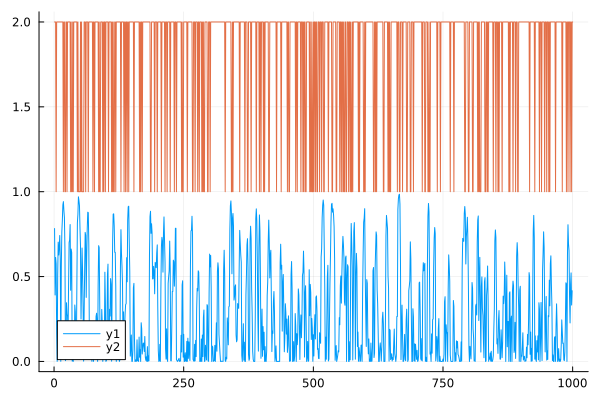

In [197]:
r1 = [count(x -> x ==1, result[:,t]) for t in 1:T ] / n_samples

plot(r1)
plot!(test_regimes)


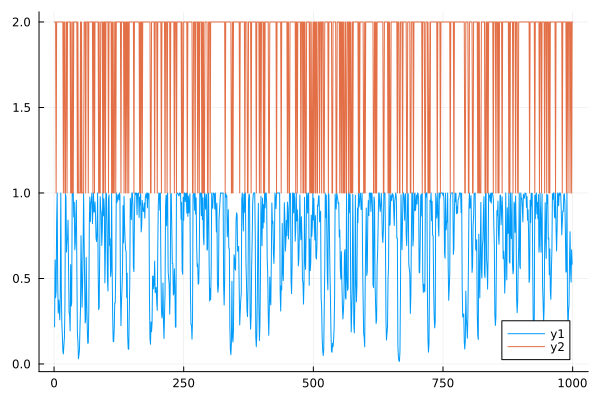

In [198]:
r2 = [count(x -> x ==2, result[:,t]) for t in 1:T ] / n_samples

plot(r2)
plot!(test_regimes)

In [199]:
n = count_regime_transitions(result[1, :], 2)


2×2 Matrix{Float64}:
 198.0   99.0
  99.0  602.0

In [200]:
n ./ sum(n, dims=2) 

2×2 Matrix{Float64}:
 0.666667  0.333333
 0.141227  0.858773

In [201]:
t_m = zeros(n_samples, 2, 2)
for n in 1:n_samples
  t_m[n, :, :] = sample_transition_matrix(result[1, :], 2)
end

mean_tm = mean(t_m, dims=1)[1,:,:]

mean_tm

2×2 Matrix{Float64}:
 0.666341  0.333659
 0.141335  0.858665

In [256]:
filter_X(Y, result[1,:], 1)

298×2 Matrix{Float64}:
  0.221563   0.115526
  0.0464621  0.167674
  0.169032   0.154635
  0.216688   0.148176
 -0.0118868  0.069093
  0.0678698  0.0471332
  0.0481536  0.105839
  0.0681527  0.129463
  0.211898   0.120297
  0.253762   0.134556
  ⋮          
  0.215428   0.0755756
  0.11998    0.115867
  0.223131   0.101317
  0.22963    0.178521
  0.0122756  0.169888
  0.032391   0.12372
  0.0422978  0.0674906
  0.318312   0.143016
  0.153924   0.174546

In [344]:
k = 2
cov_sample =zeros(n_samples, k, 2, 2)

for n in 1:n_samples
    cov_sample[n, :, :, :] = sample_covariance(Y, X, Β, result[1,:], 2)
end

cov1_mean = mean(cov_sample[:,1,:,:], dims=1)[1, :, :]
cov2_mean = mean(cov_sample[:,2,:,:], dims=1)[1, :, :] 


2×2 Matrix{Float64}:
 5.0777e-5  3.2264e-6
 3.2264e-6  1.70996e-6

In [346]:
display(cov2cor(cov1_mean))
display(sqrt.(diag(cov1_mean)))
display(cov2cor(cov2_mean))
display(sqrt.(diag(cov2_mean)))

2×2 Matrix{Float64}:
 1.0      0.39108
 0.39108  1.0

2-element Vector{Float64}:
 0.005019414519154172
 0.001932999741908708

2×2 Matrix{Float64}:
 1.0       0.346252
 0.346252  1.0

2-element Vector{Float64}:
 0.007125796021042707
 0.0013076562370906127

In [185]:
P = transition_matrix
N = size(P, 1)
        
    # Construct the matrix A for solving Ax = b where x is π
A = [P' - I; ones(1, N)]

    b = [zeros(N); 1.0]
        
    # Solve for π using backslash operator (Gaussian elimination)
    π = A \ b


2-element Vector{Float64}:
 0.5714285714285716
 0.4285714285714283

In [216]:
B = [.9, .1, 1., 1.]
b = [.9, .1, 1., 1.]

B \ b

0.9999999999999999

In [223]:
a = [1,2]
b = [3,4]


M = b*a' / a'a

M * a

2-element Vector{Float64}:
 3.0
 4.0

In [234]:
a = [.9 , .1]
b = [.9 , .1]


M = b*a' / a'a

M


2×2 Matrix{Float64}:
 0.987805  0.109756
 0.109756  0.0121951

In [231]:
transition_matrix * ones(2)

2-element Vector{Float64}:
 1.0
 1.0

In [228]:
unconditional_regimes(transition_matrix)

2-element Vector{Float64}:
 0.5714285714285716
 0.4285714285714283

In [229]:
transition_matrix' * unconditional_regimes(transition_matrix)

2-element Vector{Float64}:
 0.5714285714285715
 0.42857142857142844